In [1]:
import numpy as np
import os
from Utils.utilities import *
import h5py
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from models.cnn2d_lstm import CNN2D_LSTM_Net
from models.cnn1d_lstm import CNN_LSTM_Net
from models.tinny import TinyMEGNet, MEGNet

In [2]:
set_seed(42) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Use os.path.join() to create the correct file path
filepath = get_filepath()
print(f"Base filepath: {filepath}")

# Example usage for Intra-subject classification
intra_train_path = os.path.join(filepath, "Intra", "train")
intra_test_path = os.path.join(filepath, "Intra", "test")

# Load a small subset of files to test the function
# Downsample factor is set to 16 to speed up the process, CHANGE LATER!
train_raw, train_labels = load_h5_files(intra_train_path)
test_raw, test_labels = load_h5_files(intra_test_path)

train_data = normalize_meg_data(train_raw, downsample_factor=4)
test_data = normalize_meg_data(test_raw, downsample_factor=4)

Base filepath: c:\Users\marcd\Desktop\Master\Courses\Deep_Learning\Project_2\Final Project data\Final Project data


In [5]:
# Check training set size and distribution
print(f"Training samples: {len(train_data)}")
print(f"Training label distribution:")
for label in set(train_labels):
    count = train_labels.count(label)
    print(f"  {label}: {count}")

print(f"\nTest samples: {len(test_data)}")
print(f"Test label distribution:")
for label in set(test_labels):
    count = test_labels.count(label)
    print(f"  {label}: {count}")

Training samples: 32
Training label distribution:
  task_story: 8
  rest: 8
  task_working: 8
  task_motor: 8

Test samples: 8
Test label distribution:
  task_story: 2
  rest: 2
  task_working: 2
  task_motor: 2


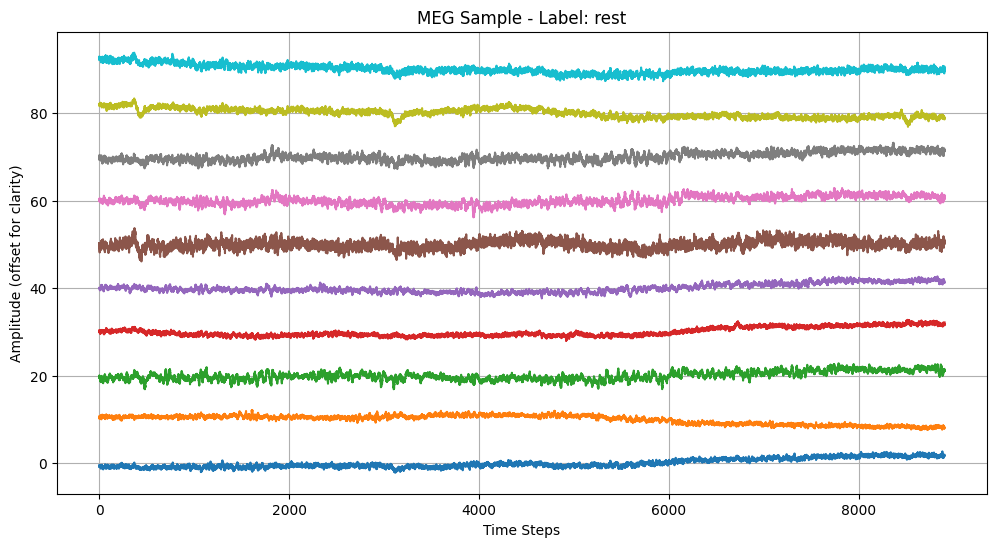

In [6]:
plot_meg_sample(train_data[0], train_labels[0])

In [7]:
# Standard class mapping for MEG tasks

LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

In [8]:
CONFIG = {
    # Model hyperparameters
    "num_classes": len(LABEL_MAP),
    "input_sensors": 248,
    "input_time_steps": train_data[0].shape[1],
    "lstm_hidden_size": 64,
    "num_lstm_layers": 2,
    "dropout": 0.3,
    
    # Training hyperparameters
    "lr": 1e-3,
    "weight_decay": 1e-3,
    "patience": 12,
    "epochs": 50,
    "batch_size": 4,
    "seed": 42,
    "n_splits": 4
}


In [9]:
model_Tiny_fn = lambda: TinyMEGNet(
    num_classes=len(LABEL_MAP),
    input_channels=248,
    input_time_steps=train_data[0].shape[1]
)

model_CNN_LSTM_fn = lambda: CNN_LSTM_Net(
    num_classes=len(LABEL_MAP),
    input_sensors=248,
    input_time_steps=train_data[0].shape[1]
)

CNN2D_LSTM_Net_fn = lambda: CNN2D_LSTM_Net(
    num_classes=CONFIG["num_classes"],
    input_sensors=CONFIG["input_sensors"],
    input_time_steps=CONFIG["input_time_steps"],
    lstm_hidden_size=CONFIG["lstm_hidden_size"],
    num_lstm_layers=CONFIG["num_lstm_layers"],
    dropout=CONFIG["dropout"],
)

In [10]:
# Run Experiment (cross-validation or train/val/test split)
fold_results, all_histories = cross_validation_experiment(
    all_data           =    train_data,
    all_labels         =    train_labels,
    label_map          =    LABEL_MAP,
    model_fn           =    CNN2D_LSTM_Net_fn,
    lr                 =    CONFIG["lr"],
    weight_decay       =    CONFIG["weight_decay"],
    patience           =    CONFIG["patience"],
    n_splits           =    CONFIG["n_splits"],
    epochs             =    CONFIG["epochs"],
    batch_size         =    CONFIG["batch_size"],
    seed               =    CONFIG["seed"]
)


  CROSS-VALIDATION EXPERIMENT (4 folds)
Total samples: 32
Samples per fold - Train: ~24, Val: ~8

--- FOLD 1/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3968
  - Sequence length: 594
  - Parameters: 2,269,700
Epoch  0: Train Acc=0.250, Val Acc=0.250, Val Loss=1.381
Epoch 10: Train Acc=0.708, Val Acc=0.625, Val Loss=0.909
Epoch 20: Train Acc=0.917, Val Acc=0.500, Val Loss=1.177
Early stopping at epoch 23
Fold 1 Best Val Accuracy: 0.7500

--- FOLD 2/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3968
  - Sequence length: 594
  - Parameters: 2,269,700
Epoch  0: Train Acc=0.167, Val Acc=0.250, Val Loss=1.383
Epoch 10: Train Acc=0.667, Val Acc=0.500, Val Loss=0.930
Epoch 20: Train Acc=0.958, Val Acc=0.750, Val Loss=1.101
Early stopping at epoch 26
Fold 2 Best Val Accuracy: 0.7500

--- FOLD 3/4 ---
2D CNN + LSTM Net initialized:
  - LSTM input size: 3968
  - Sequence length: 594
  - Parameters: 2,269,700
Epoch  0: Train Acc=0.167, Val Acc=0.250, Val Loss=1.385
Epoch


  CROSS-VALIDATION RESULTS SUMMARY

Best Validation Accuracies per Fold:
  Fold 1: 0.7500 (75.00%)
  Fold 2: 0.7500 (75.00%)
  Fold 3: 0.5000 (50.00%)
  Fold 4: 0.6250 (62.50%)

Cross-Validation Summary:
  Mean Accuracy: 0.6562 ± 0.1036
  Best Fold: 0.7500
  Worst Fold: 0.5000


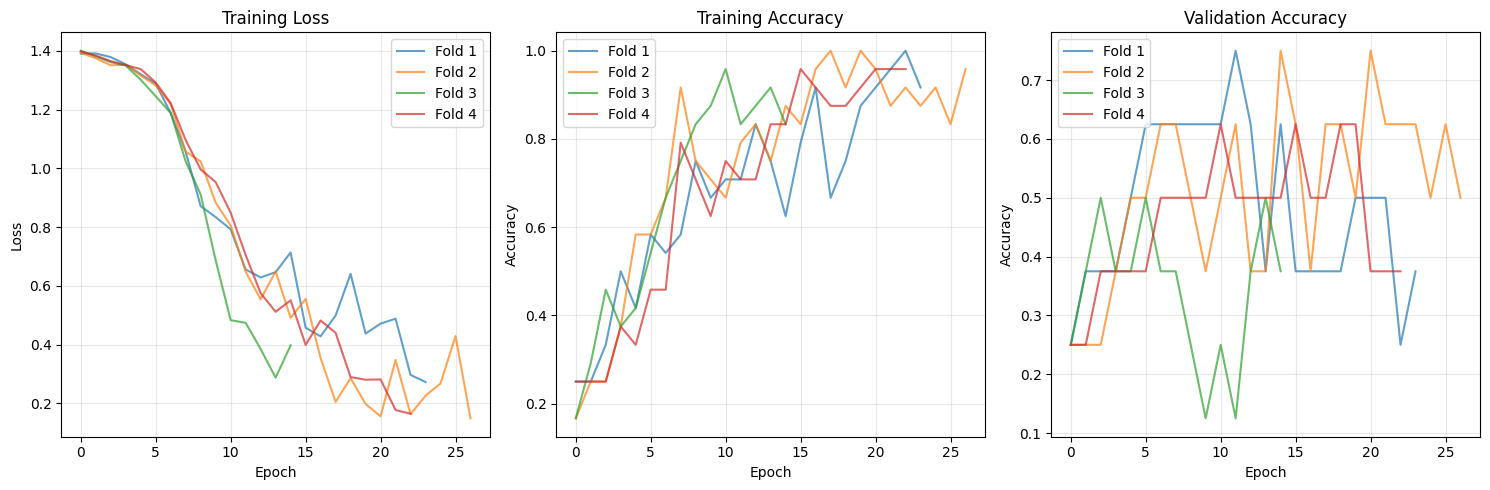

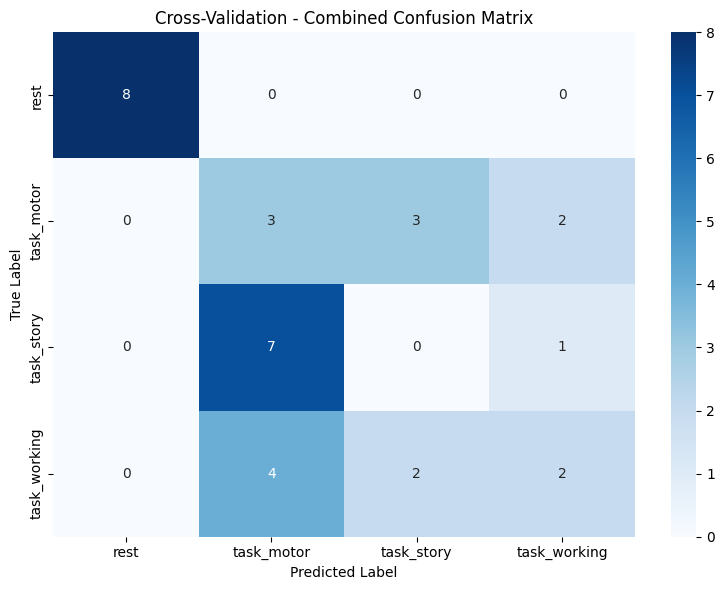

In [11]:
# Analyze results
mean_acc, std_acc = analyze_cv_results(fold_results, all_histories, LABEL_MAP)